In [2]:
import tensorflow as tf
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv.__version__)

TensorFlow version: 2.15.0
OpenCV version: 4.9.0


Preprocesamiento de la imagen

In [3]:
def z_score_normalization(image):
    mean, std = image.mean(), image.std()
    return (image - mean) / std

def preprocess_image(image):
    if image is None:
        print(f"Error cargando la imagen.")
        return None, None
    
    image = cv.resize(image, (224, 224)).astype(np.float32)
    kernel_size = 15
    
    low_freq_image = cv.GaussianBlur(image, (kernel_size, kernel_size), 0)
    low_freq_image = z_score_normalization(low_freq_image)
    
    laplacian = cv.Laplacian(image, cv.CV_32F)
    high_freq_image = z_score_normalization(laplacian)
    
    return low_freq_image, high_freq_image

# Esta funcion se utiliza para poder visualizar que se ha realizado el preprocesamiento correcta, puesto que la normalización z score imposibilita la visualizacion normal de la imagen, 
# aunque facilita el entrenamiento de la red neuronal.
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val) * 255
    normalized_image = np.uint8(normalized_image)
    return normalized_image

Test de preprocesamiento:

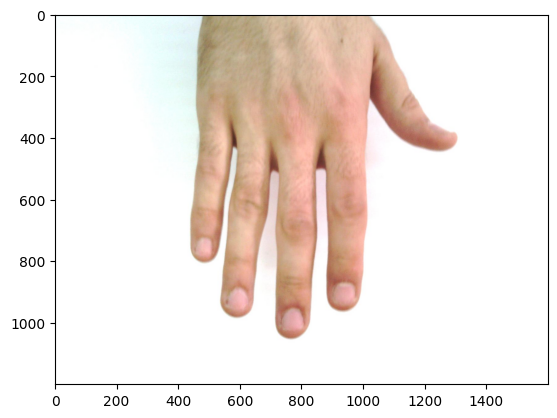

In [21]:
img = cv.imread("D:/UNIVERSIDAD/4/PID/Proyecto2/genero_manos/dataset/Hands/Hand_0000002.jpg", cv.IMREAD_COLOR)

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

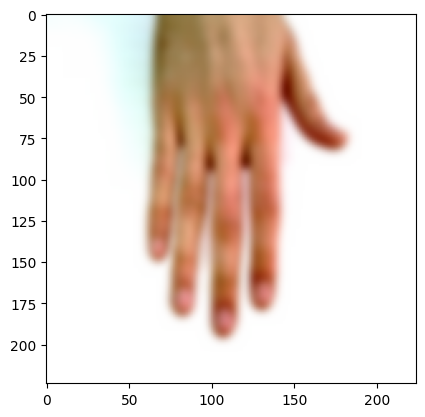

In [22]:
l, h = preprocess_image(img)

plt.imshow(normalize(cv.cvtColor(l, cv.COLOR_BGR2RGB)))

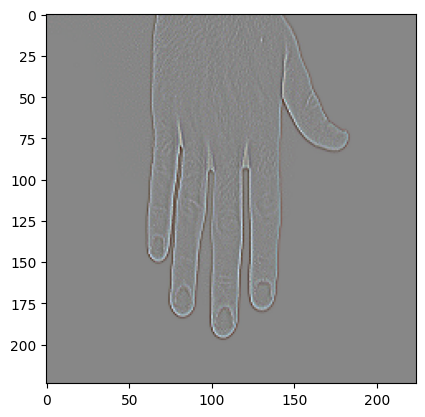

In [23]:
plt.imshow(normalize(cv.cvtColor(h, cv.COLOR_BGR2RGB)))

Carga y preprocesado del dataset

In [4]:
def load_and_preprocess_data(dataset_path):
    image_folder = os.path.join(dataset_path, 'Hands')
    csv_file = os.path.join(dataset_path, 'HandInfo.csv') 
    csv = pd.read_csv(csv_file)
    low_freq_images = []
    high_freq_images = []
    labels = []
    
    for _, row in csv.iterrows():
        image_name = f"Hand_{row['id']}.jpg"
        gender = row['gender']
        image_path = os.path.join(image_folder, image_name)
        
        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        low_freq, high_freq = preprocess_image(image)
        if low_freq is not None and high_freq is not None:
            low_freq_images.append(low_freq[..., np.newaxis])
            high_freq_images.append(high_freq[..., np.newaxis])
            labels.append(gender)
            
    unique_labels = list(set(labels))
    label_map = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = [label_map[label] for label in labels]
            
    return np.array(low_freq_images), np.array(high_freq_images), np.array(numeric_labels)